2022-09-15

1. EC를 추가

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + EC*(x**5)

2. 두가지 경우 비교

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + w5*(x**5)

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + EC*(x**5)

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + sigmoid* w *(x**5)

2022-09-20

loss =

[f(1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4)) - {w1 + 2*w2 + 3*w3*(x**2) + 4*w4*(x**3)}
 + f(EC)*(x**5) - {5*f(EC)*(x**4) + d_EC*(x**5)}]**2

 [f(1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4)) - {w1 + 2*w2 + 3*w3*(x**2) + 4*w4*(x**3)}]**2
 + [f(EC)*(x**5) - {5*f(EC)*(x**4) + d_EC*(x**5)}]**2

2022-09-29

Work 1

1 : ODE 4차 오차 감소율 없을때 출력

2 : ODE 5차 오차 감소율 없을때 출력

3 : ODE 4차 + EC Case1 w 계수들 exact 계수들과 일치하는 경우에 대해서 비교

2022-09-29

Work 2

System of ODE

Y'(x) = lambda * Y(x)

where Y(x) = [[y1(x)], [y2(x)]] & lambda = [[lamb1, 0], [0, lamb2]] and lamb1 != lamb2
                                  

2022-10-05, 10-10

Exam 2

Prothero Robinson Equation

P'(t) = v(P(t) - g(t)) + g'(t), 0 <= t <= 1; P(0) = 0

v = -1, g(t) = sin(t)

loss = - P'(x) - v(P(x) - sin(x)) + cos(x)


Exam 3

비선형

y' = y**2

loss = y**2 - y'

Module import

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

Solve the following initial value differential equation $$ y'=\lambda y,  \quad  y(0)=y_0$$

Fuction Define

In [2]:
# analysis 함수 
def anal(x, lamb):
    return np.exp(lamb*x)

def exam3(x):
    return -1 / (1 + x)

# n : w 개수, w : weight
def y(x, w, n = 4, bias = 1):
    y = bias         # y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4)
    for i in range(1, n+1):
        y += w[i-1]*(x**i)
    
    return y

def yprime(x, w, n = 4):
    yprime = 0    # yprime = w1 + 2*w2*x + 3*w3*(x**2) + 4*w4*(x**3)
    for i in range(1, n + 1):
        yprime += i*w[i-1]*(x**(i-1))

    return yprime

def exam2_loss(x, y, y_prime, v = 1):
    loss = - y_prime - v(y - tf.math.sin(x)) + tf.math.cos(x)
    return loss

def exam3_loss(y, y_prime):
    loss = y**2 - y_prime
    return loss

def f(y, lamb):
    return lamb*y

def sigmoid(x):
    return tf.math.sigmoid(x)

def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

def neural_network(W, x):
    a1 = sigmoid(tf.experimental.numpy.dot(x, W[0]))
    return tf.experimental.numpy.dot(a1, W[1])

def d_neural_network_dx(W, x, k=1):
    return tf.experimental.numpy.dot(tf.experimental.numpy.dot(tf.transpose(W[1]), tf.transpose(W[0])**k), sigmoid_grad(x))

def net_out(W):
    return neural_network(W, 1)

def EC_predict(W, x, lamb, n):
    return f(net_out(W)*x**(n+1), lamb)

def d_net_out(W, x):
    return d_neural_network_dx(W, x)

# 수정
def EC_d_y(W, x, n):
    return (n+1)*(x**n)*net_out(W)

ODE

n : 차수

target_loss : 이전 학습 loss_sum의 차가 target_loss 보다 작으면 멈춤

early_stop : loss_sum 최소값 뒤로 최소값 갱신이 되지 않고, 정해진 값 이상 Epoch가 진행 되면 중단

learing_rate : 학습률

max_train_count : 최대 학습 횟수

In [3]:
def ODE_train(n = 4, target_loss = np.Inf, early_stop = np.Inf, max_train_count = np.Inf, show_w_trace = True, show_loss_trace = True, show_error = True, show_compare_analysis = True):
    # 최대 x 범위 : 0 <= x < x_max, lambda 값
    x_max = 1
    x_slice = 100
    x = tf.Variable(np.array([[i/x_slice] for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
    lamb = -1.0

    # 차수, weight 개수
    w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32), trainable=True) # w = [weight1, weight2, weight3, weight4, ... , weight(n)]

    # 변화 w 값, loss 저장
    w_trace = []
    w_trace.append(w.numpy())
    loss_trace = []

    # 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
    Epoch = 0

    # y' = f(y, t)를 만족하는 y 찾는 과정
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    # 학습 과정
    low_loss = np.inf
    low_loss_Epoch = 0
    while True:
        Epoch += 1
        loss_sum = 0.0
        for x_unit in x:
            with tf.GradientTape() as tape:
                # 예측 값
                _y = y(x_unit, w, n, bias = 0)
                y_prime = yprime(x_unit, w, n)
                # y' = f(y, t)
                loss = tf.square(exam3_loss(_y, y_prime))
                loss_sum += loss

            # Gradient 값 저장
            gradients = tape.gradient(loss, w)
            # Gradient 값 w에 적용
            optimizer.apply_gradients(zip([gradients], [w]))
        
        # w 변화값 저장
        w_trace.append(w.numpy())

        # Epoch별 loss 합 저장
        loss_sum = float(loss_sum)
        loss_trace.append(loss_sum)
        
        # early stop
        if target_loss >= loss_sum and low_loss > loss_sum:
            low_loss = loss_sum
            early_stop_w = w
            low_loss_Epoch = Epoch
        
        if low_loss_Epoch + early_stop <= Epoch:
            print('early stop')
            break
        
        if np.isnan(loss_sum):
            print('break nan')
            break

        if Epoch % 100 == 0:
            print('Epoch : {}, Loss_sum : {:.4f}, w : {}'.format(Epoch, loss_sum, w.numpy()))

        if Epoch == max_train_count:
            print('max count')
            break
        
    print('low_loss_Epoch : {}, low_Loss_sum : {:.4f}, low_loss_w : {}'.format(low_loss_Epoch, low_loss, early_stop_w))

    if show_w_trace:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_title('Weight & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Weight')
        ax.plot(w_trace, label = ['w{}'.format(i+1) for i in range(n)])
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=10)
        ax.grid()

    if show_loss_trace:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_title('Loss & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.plot(loss_trace, label = 'loss')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_error:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.plot(abs(y(x, early_stop_w, n) - exam3(x)), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_compare_analysis:
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.set_title('Analysis & f(lambda*y) & Error')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.plot(exam3(x), label = 'analysis')
        ax.plot(y(x, early_stop_w, n), label = 'y')
        # ax.plot(y(x, w, n) + net_out(W)*x**5, label = 'add_EC')
        # ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    return early_stop_w

ODE + EC

n : 차수

EC_n : EC weight 개수 (가로, 세로 두 곳 다 적용)

target_loss : loss_sum이 target_loss 보다 작아지면 early_stop 조건에 들어간다. 

early_stop : loss_sum 최소값 뒤로 최소값 갱신이 되지 않고, 정해진 값 이상 Epoch가 진행 되면 중단

learing_rate : 학습률

max_train_count : 최대 학습 횟수

In [15]:
def ODE_EC_Case1_train(n = 4, EC_n = 10, target_loss = np.Inf, early_stop = np.Inf, max_train_count = np.Inf, show_w_trace = True, show_loss_trace = True, show_error = True, show_compare_analysis = True):
    # 최대 x 범위 : 0 <= x < x_max, lambda 값
    x_max = 1
    x_slice = 100
    x = tf.Variable(np.array([[i/x_slice] for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
    lamb = -1.0

    # 차수, weight 개수
    w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32), trainable=True) # w = [weight1, weight2, weight3, weight4]

    # EC, Weight 개수
    # W = [[1, EC_n], [EC_n, 1]]
    W = [tf.Variable(tf.random.normal(shape=(1, EC_n), dtype=tf.float32), trainable=True), tf.Variable(tf.random.normal(shape=(EC_n, 1), dtype=tf.float32), trainable=True)] 

    # 변화 w 값, loss 저장
    w_trace = [np.append(np.array(w.numpy()), net_out(W).numpy())]
    loss_trace = []

    # 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
    Epoch = 0
    
    # y' = f(y, t)를 만족하는 y 찾는 과정
    EC_optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    # 학습 과정
    low_loss = np.inf
    low_loss_Epoch = 0
    while True:
        Epoch += 1
        loss_sum = 0.0
        for x_unit in x:
            with tf.GradientTape() as tape:
                # 예측 값
                _y = y(x_unit, w, n, bias = 0) + EC_predict(W, x_unit, n)
                y_prime = yprime(x_unit, w, n) + EC_d_y(W, x_unit, n)
                # y' = f(y, t)
                loss = tf.square(exam3_loss(_y, y_prime))
                loss_sum += loss
            
            # Gradient 값 저장
            [gradients, EC_gradients] = tape.gradient(loss, [w, W])
            # Gradient 값 w에 적용
            EC_optimizer.apply_gradients(zip([gradients, EC_gradients[0], EC_gradients[1]], [w, W[0], W[1]]))
            
        # w 변화값 저장
        total_w = np.append(np.array(w.numpy()), net_out(W).numpy())
        w_trace.append(total_w)

        # Epoch별 loss 합 저장
        loss_sum = float(loss_sum)
        loss_trace.append(loss_sum)

        # early stop
        if target_loss >= loss_sum and  low_loss > loss_sum:
            low_loss = loss_sum
            early_stop_w = w, W
            low_loss_Epoch = Epoch
        
        if low_loss_Epoch + early_stop <= Epoch:
            print('early_stop')
            break

        if np.isnan(loss_sum):
            print('break nan')
            break
        
        if Epoch % 100 == 0:
            print('Epoch : {}, Loss_sum : {:.4f}, w : {}'.format(Epoch, loss_sum, total_w))

        if Epoch == max_train_count:
            print('max count')
            break
        
    print('low_loss_Epoch : {}, low_Loss_sum : {:.4f}, low_loss_w : {}'.format(low_loss_Epoch, low_loss, early_stop_w))

    if show_w_trace:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_title('Weight & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Weight')
        ax.plot(w_trace, label = ['w{}'.format(i+1) for i in range(n)] + ['NN'])
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=10)
        ax.grid()
    
    if show_loss_trace:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_title('Loss & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.plot(loss_trace, label = 'loss')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_error:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.plot(abs(y(x, early_stop_w[0], n) + EC_predict(early_stop_w[1], x, n) - exam3(x)), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_compare_analysis:
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.set_title('Analysis & f(lambda*y) & Error')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.plot(exam3(x), label = 'analysis')
        # ax.plot(y(x, w, n), label = 'y')
        ax.plot(y(x, early_stop_w[0], n) + EC_predict(early_stop_w[1], x, n), label = 'add_EC')
        # ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    return early_stop_w

In [ ]:
def ODE_EC_Case2_train(n = 4, EC_n = 10, target_loss = np.Inf, early_stop = np.Inf, max_train_count = np.Inf, show_w_trace = True, show_loss_trace = True, show_error = True, show_compare_analysis = True):
    # 최대 x 범위 : 0 <= x < x_max, lambda 값
    x_max = 1
    x_slice = 100
    x = tf.Variable(np.array([[i/x_slice] for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
    lamb = -1.0

    # 차수, weight 개수
    w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32), trainable=True) # w = [weight1, weight2, weight3, weight4]

    # EC, Weight 개수
    # W = [[1, EC_n], [EC_n, 1]]
    W = [tf.Variable(tf.random.normal(shape=(1, EC_n), dtype=tf.float32), trainable=True), tf.Variable(tf.random.normal(shape=(EC_n, 1), dtype=tf.float32), trainable=True)] 

    # 변화 w 값, loss 저장
    w_trace = [np.append(np.array(w.numpy()), net_out(W).numpy())]
    loss_trace = []

    # 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
    Epoch = 0
    
    # y' = f(y, t)를 만족하는 y 찾는 과정
    EC_optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    # 학습 과정
    low_loss = np.inf
    low_loss_Epoch = 0
    while True:
        Epoch += 1
        loss_sum = 0.0
        for x_unit in x:
            with tf.GradientTape() as tape:
                # 예측 값
                _y = y(x_unit, w, n, bias = 0)
                EC = f(EC_predict(W, x_unit, lamb, n), lamb)
                y_prime = yprime(x_unit, w, n)
                d_EC = EC_d_y(W, x_unit, n)
                # y' = f(y, t)
                loss = tf.square(exam3_loss(_y, y_prime)) + tf.square(EC - d_EC)
                loss_sum += loss
            
            # Gradient 값 저장
            [gradients, EC_gradients] = tape.gradient(loss, [w, W])
            # Gradient 값 w에 적용
            EC_optimizer.apply_gradients(zip([gradients, EC_gradients[0], EC_gradients[1]], [w, W[0], W[1]]))
            
        # w 변화값 저장
        total_w = np.append(np.array(w.numpy()), net_out(W).numpy())
        w_trace.append(total_w)

        # Epoch별 loss 합 저장
        loss_sum = float(loss_sum)
        loss_trace.append(loss_sum)

        # early stop
        if target_loss >= loss_sum and  low_loss > loss_sum:
            low_loss = loss_sum
            early_stop_w = w, W
            low_loss_Epoch = Epoch
        
        if low_loss_Epoch + early_stop <= Epoch:
            print('early_stop')
            break

        if np.isnan(loss_sum):
            print('break nan')
            break
        
        if Epoch % 100 == 0:
            print('Epoch : {}, Loss_sum : {:.4f}, w : {}'.format(Epoch, loss_sum, total_w))

        if Epoch == max_train_count:
            print('max count')
            break
        
    print('low_loss_Epoch : {}, low_Loss_sum : {:.4f}, low_loss_w : {}'.format(low_loss_Epoch, low_loss, early_stop_w))

    if show_w_trace:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_title('Weight & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Weight')
        ax.plot(w_trace, label = ['w{}'.format(i+1) for i in range(n)] + ['NN'])
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=10)
        ax.grid()
    
    if show_loss_trace:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_title('Loss & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.plot(loss_trace, label = 'loss')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_error:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.plot(abs(y(x, early_stop_w[0], n) + EC_predict(early_stop_w[1], x, n) - exam3(x)), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_compare_analysis:
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.set_title('Analysis & f(lambda*y) & Error')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.plot(exam3(x), label = 'analysis')
        # ax.plot(y(x, w, n), label = 'y')
        ax.plot(y(x, early_stop_w[0], n) + EC_predict(early_stop_w[1], x, n), label = 'add_EC')
        # ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    return early_stop_w

Train

----------------------------------

Epoch : 100, Loss_sum : 1.9678, w : [-0.921061    0.27982923]
Epoch : 200, Loss_sum : 2.1154, w : [-0.91354233  0.2767373 ]
Epoch : 300, Loss_sum : 2.1363, w : [-0.91362983  0.27590048]
Epoch : 400, Loss_sum : 1.9614, w : [-0.91738087  0.27832922]
Epoch : 500, Loss_sum : 1.9643, w : [-0.91569304  0.27794617]
low_loss_Epoch : 90, low_Loss_sum : 1.6690, low_loss_w : <tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([-0.9103028 ,  0.27308533], dtype=float32)>


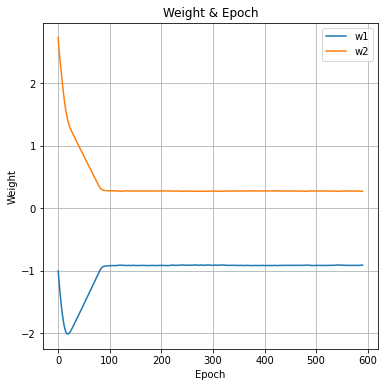

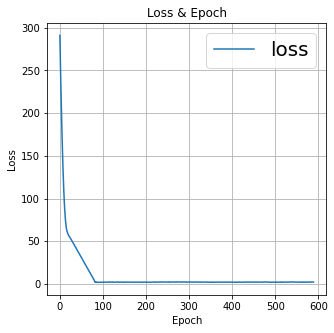

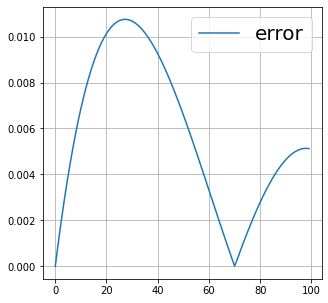

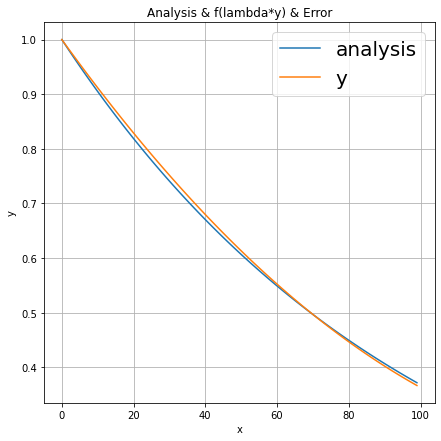

In [5]:
w4_train = ODE_train(n = 4, early_stop = 500, max_train_count = 2000)

Epoch : 100, Loss_sum : 16.8423, w : [-0.41631854 -0.77081406  0.5811179 ]
Epoch : 200, Loss_sum : 11.0082, w : [-0.61838794 -0.2857142   0.28697553]
Epoch : 300, Loss_sum : 4.1961, w : [-0.8334177   0.14532392  0.05645427]
Epoch : 400, Loss_sum : 0.5462, w : [-0.9687279   0.41088942 -0.07261268]
Epoch : 500, Loss_sum : 0.2276, w : [-0.99611574  0.45742303 -0.09515708]
Epoch : 600, Loss_sum : 0.1208, w : [-0.9948521   0.45800188 -0.09584638]
Epoch : 700, Loss_sum : 0.1767, w : [-0.9881698   0.45872107 -0.09979968]
Epoch : 800, Loss_sum : 0.1473, w : [-0.99287003  0.45618117 -0.09551761]
Epoch : 900, Loss_sum : 0.0852, w : [-0.9982456   0.4563049  -0.09402475]
Epoch : 1000, Loss_sum : 0.1435, w : [-0.9923897   0.4568227  -0.09687026]
Epoch : 1100, Loss_sum : 0.1246, w : [-0.99630404  0.4574094  -0.0944572 ]
low_loss_Epoch : 622, low_Loss_sum : 0.0709, low_loss_w : <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([-0.99462724,  0.4648762 , -0.10022638], dtype=float32)>


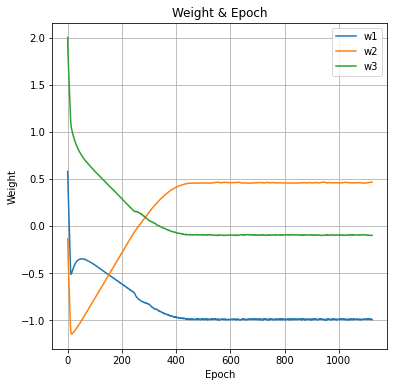

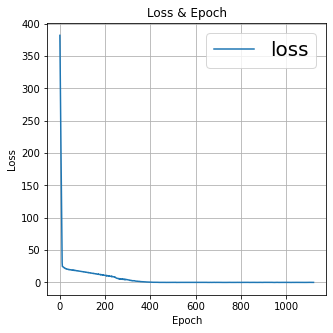

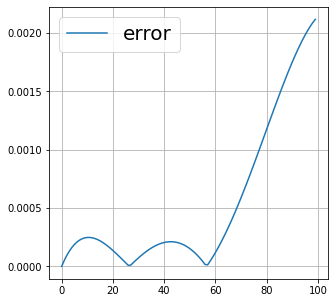

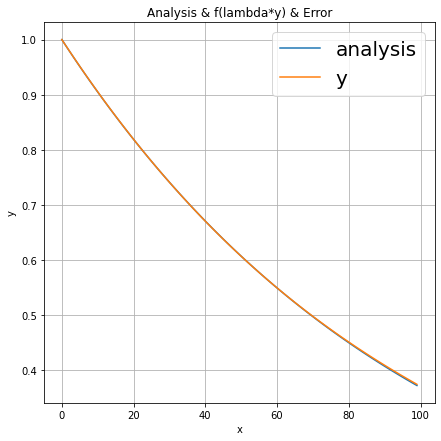

In [6]:
w5_train = ODE_train(n = 5, target_loss = 2, early_stop = 500, max_train_count = 2000)

In [16]:
w4_EC_Case1_train = ODE_EC_Case1_train(n = 4, EC_n = 10, early_stop = 500, max_train_count = 2000)

Epoch : 100, Loss_sum : 6.7019
Epoch : 200, Loss_sum : 0.8788
Epoch : 300, Loss_sum : 0.0033
Epoch : 400, Loss_sum : 0.0019


In [ ]:
w4_EC_Case2_train = ODE_EC_Case2_train(n = 4, EC_n = 10, early_stop = 500, max_train_count = 2000)

In [ ]:
# 2022.07.20
# 에러 그래프 부분 보강
# epoch 늘려서 학습 결과 찾기
# w 값 
# w1 = lambda와 비슷하게 -2
# w2 = 2
# w3 = -1
# w4 = 0.5
# layer 구조 확인

# 2022.08.03
# 모델 부분 input -> layer -> layer -> output
# layer 추가 할 수 있게 만들어 놓기

# 2022.08.23
# x 범위 증가 대신 개수 증가로 0 ~ 1 사이
# 코드 공유
# Error 파트 layer 추가
# Solution + Error
##  추가 학습 필요 내용 ## 
# Error에 따른 weight 업데이트 과정 수식 확인
# 비지도 학습 진행과정


In [ ]:
x_max = 1
x_slice = 100
x = tf.Variable(np.array([[i/x_slice] for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
lamb = -1.0
n = 4

poly_w = [-1, 1/2, -1/6, 1/24, -1/120]

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(abs(y(x, w4_train, 4) - exam3(x)), label = 'w4')
ax.plot(abs(y(x, w5_train, 5) - exam3(x)), label = 'w5')
ax.plot(abs(y(x, w4_EC_Case1_train[0], 4) + EC_predict(w4_EC_Case1_train[1], x, n) - exam3(x)), label = 'w4+EC_Case1')
ax.plot(abs(y(x, w4_EC_Case2_train[0], 4) + EC_predict(w4_EC_Case2_train[1], x, n) - exam3(x)), label = 'w4+EC_Case2')
ax.plot(abs(y(x, poly_w[:4], 4) - exam3(x)), '--', label = 'w4_poly_error')
ax.plot(abs(y(x, poly_w[:5], 5) - exam3(x)), '--', label = 'w5_poly_error')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()